<a href="https://colab.research.google.com/github/tig1795/predicting_hits_ML_MA/blob/main/XGBoost_small_dataset_af_lyrics_sent_emos_other_hit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


# Important Imports

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Datasets/dataset_ML_complete.csv')

In [6]:
data.head()

,lyrics,genre,num_syllables,pos,year,fog_index,flesch_index,num_lines,sentiment,title,...,duration_ms,Popularity,values,pred,label,score,emotion_label,Hit,Hit_2,Hit_3
0,look into my eyes you will seewhat you mean t...,"['acoustic rock', 'adult contemporary', 'album...",258.3,1,1991,4.4,107.69,36,"{'neg': 0.14100000000000001, 'neu': 0.708, 'po...",(Everything I Do) I Do It For You,...,393640,77.0,1.000000,1,POSITIVE,0.998717,joy,Yes,yes,yes
1,i can't get no satisfactioni can't get no sati...,"['blues', 'blues rock', 'britannique', 'britis...",296.1,3,1965,4.8,106.67,37,"{'neg': 0.126, 'neu': 0.667, 'pos': 0.20800000...",(I Can't Get No) Satisfaction,...,222813,78.0,0.333333,0,NEGATIVE,0.999485,joy,Yes,no,yes
2,our life together is so precious togetherwe ha...,"['britannique', 'british', 'classic pop and ro...",288.0,4,1981,4.8,81.29,28,"{'neg': 0.068, 'neu': 0.625, 'pos': 0.308, 'co...",(Just Like) Starting Over,...,236547,61.0,0.250000,1,POSITIVE,0.998593,joy,Yes,no,yes
3,love is higher than a mountain love is thicker...,"['classic pop and rock', 'death by myocarditis']",224.1,8,1978,4.0,91.78,30,"{'neg': 0.062, 'neu': 0.7000000000000001, 'pos...",(Love Is) Thicker Than Water,...,255960,47.0,0.125000,1,POSITIVE,0.998285,sadness,Yes,no,yes
4,sittin' in the morning suni'll be sittin' when...,"['american', 'blues', 'death by airplane', 'de...",223.2,4,1968,4.8,98.21,25,"{'neg': 0.018000000000000002, 'neu': 0.927, 'p...",(Sittin' On) The Dock Of The Bay,...,163756,80.0,0.250000,0,NEGATIVE,0.994735,joy,Yes,no,yes


In [7]:
data.shape

(3664, 47)

In [8]:
data.columns

Index(['lyrics', 'genre', 'num_syllables', 'pos', 'year', 'fog_index',
       'flesch_index', 'num_lines', 'sentiment', 'title', 'f_k_grade',
       'artist', 'difficult_words', 'num_dupes', 'number_of_tokens',
       'number_of_types', 'decades', 'stemmed_text', 'POS_tags', 'POS',
       'playlistID', 'TrackName', 'TrackID', 'SampleURL', 'ReleaseYear',
       'Genres', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'key', 'mode', 'duration_ms', 'Popularity', 'values', 'pred', 'label',
       'score', 'emotion_label', 'Hit', 'Hit_2', 'Hit_3'],
      dtype='object')

In [9]:
data = data.drop(['genre', 'num_syllables', 'pos', 'year', 'fog_index',
       'flesch_index', 'num_lines', 'sentiment','f_k_grade', 'difficult_words', 'num_dupes', 'number_of_tokens',
       'number_of_types', 'decades', 'stemmed_text', 'POS_tags', 'POS','values', 'pred'], axis=1)

In [10]:
data.head(5)

,lyrics,title,artist,playlistID,TrackName,TrackID,SampleURL,ReleaseYear,Genres,danceability,...,key,mode,duration_ms,Popularity,label,score,emotion_label,Hit,Hit_2,Hit_3
0,look into my eyes you will seewhat you mean t...,(Everything I Do) I Do It For You,Bryan Adams,2A4YfptOVIqtSvTQ6d32sm,(Everything I Do) I Do It For You,1Eb90nmqTrxylKFhcUzW8P,https://p.scdn.co/mp3-preview/b69589f6d0950835...,1991-09-24,"['canadian pop', 'canadian singer-songwriter',...",0.533,...,1,1,393640,77.0,POSITIVE,0.998717,joy,Yes,yes,yes
1,i can't get no satisfactioni can't get no sati...,(I Can't Get No) Satisfaction,Rolling Stones,2A4YfptOVIqtSvTQ6d32sm,(I Can't Get No) Satisfaction - Mono Version,2PzU4IB8Dr6mxV3lHuaG34,https://p.scdn.co/mp3-preview/22782e4be2eb4daa...,1965-07-30,"['album rock', 'british invasion', 'classic ro...",0.723,...,2,1,222813,78.0,NEGATIVE,0.999485,joy,Yes,no,yes
2,our life together is so precious togetherwe ha...,(Just Like) Starting Over,John Lennon,2A4YfptOVIqtSvTQ6d32sm,(Just Like) Starting Over - Remastered 2010,5y0YreEOnQiKFAnCrcFIXz,https://p.scdn.co/mp3-preview/a79a8808230f4ded...,1980-11-17,"['beatlesque', 'classic rock', 'rock']",0.701,...,9,1,236547,61.0,POSITIVE,0.998593,joy,Yes,no,yes
3,love is higher than a mountain love is thicker...,(Love Is) Thicker Than Water,Andy Gibb,2A4YfptOVIqtSvTQ6d32sm,(Love Is) Thicker Than Water,3jdBf1cJ2QmTzNUixplppA,https://p.scdn.co/mp3-preview/ce0e47fb6c886802...,1977-01-01,"['disco', 'mellow gold', 'soft rock']",0.582,...,6,0,255960,47.0,POSITIVE,0.998285,sadness,Yes,no,yes
4,sittin' in the morning suni'll be sittin' when...,(Sittin' On) The Dock Of The Bay,Otis Redding,2A4YfptOVIqtSvTQ6d32sm,(Sittin' On) the Dock of the Bay,3zBhihYUHBmGd2bcQIobrF,https://p.scdn.co/mp3-preview/404976a4a56d8c1c...,1968,"['classic soul', 'memphis soul', 'soul', 'soul...",0.769,...,2,1,163756,80.0,NEGATIVE,0.994735,joy,Yes,no,yes


In [11]:
data = data.drop(['playlistID', 'TrackName', 'SampleURL', 'ReleaseYear', 'Genres', 'score'], axis=1)

In [12]:
data.head(5)

,lyrics,title,artist,TrackID,danceability,energy,loudness,speechiness,acousticness,instrumentalness,...,tempo,key,mode,duration_ms,Popularity,label,emotion_label,Hit,Hit_2,Hit_3
0,look into my eyes you will seewhat you mean t...,(Everything I Do) I Do It For You,Bryan Adams,1Eb90nmqTrxylKFhcUzW8P,0.533,0.360,-12.633,0.0282,0.0805,0.000010,...,131.229,1,1,393640,77.0,POSITIVE,joy,Yes,yes,yes
1,i can't get no satisfactioni can't get no sati...,(I Can't Get No) Satisfaction,Rolling Stones,2PzU4IB8Dr6mxV3lHuaG34,0.723,0.863,-7.890,0.0338,0.0383,0.031700,...,136.302,2,1,222813,78.0,NEGATIVE,joy,Yes,no,yes
2,our life together is so precious togetherwe ha...,(Just Like) Starting Over,John Lennon,5y0YreEOnQiKFAnCrcFIXz,0.701,0.790,-6.160,0.0725,0.3010,0.000061,...,99.104,9,1,236547,61.0,POSITIVE,joy,Yes,no,yes
3,love is higher than a mountain love is thicker...,(Love Is) Thicker Than Water,Andy Gibb,3jdBf1cJ2QmTzNUixplppA,0.582,0.462,-9.882,0.0254,0.1370,0.000050,...,96.361,6,0,255960,47.0,POSITIVE,sadness,Yes,no,yes
4,sittin' in the morning suni'll be sittin' when...,(Sittin' On) The Dock Of The Bay,Otis Redding,3zBhihYUHBmGd2bcQIobrF,0.769,0.367,-11.226,0.0312,0.6840,0.000016,...,103.621,2,1,163756,80.0,NEGATIVE,joy,Yes,no,yes


In [13]:
from collections import Counter

Counter(data.Hit_3)

Counter({'yes': 1830, 'no': 1834})

In [14]:
data.Hit_3 = data.Hit_3.replace({'yes': 1, 'no': 0})

In [15]:
from collections import Counter

Counter(data.Hit_3)

Counter({1: 1830, 0: 1834})

In [16]:
data.label = data.label.replace({'POSITIVE': 1, 'NEGATIVE': 0})

In [17]:
Counter(data.label)

Counter({1: 2719, 0: 945})

In [18]:
Counter(data.emotion_label)

Counter({' joy': 1762,
         ' sadness': 928,
         ' fear': 252,
         ' love': 280,
         ' anger': 409,
         ' surprise': 33})

In [19]:
data.emotion_label = data.emotion_label.replace({' sadness': 0, ' joy': 1, ' love': 2, ' anger': 3, ' fear': 4, ' surprise': 5})

In [20]:
Counter(data.emotion_label)

Counter({1: 1762, 0: 928, 4: 252, 2: 280, 3: 409, 5: 33})

In [21]:
data.head(5)

,lyrics,title,artist,TrackID,danceability,energy,loudness,speechiness,acousticness,instrumentalness,...,tempo,key,mode,duration_ms,Popularity,label,emotion_label,Hit,Hit_2,Hit_3
0,look into my eyes you will seewhat you mean t...,(Everything I Do) I Do It For You,Bryan Adams,1Eb90nmqTrxylKFhcUzW8P,0.533,0.360,-12.633,0.0282,0.0805,0.000010,...,131.229,1,1,393640,77.0,1,1,Yes,yes,1
1,i can't get no satisfactioni can't get no sati...,(I Can't Get No) Satisfaction,Rolling Stones,2PzU4IB8Dr6mxV3lHuaG34,0.723,0.863,-7.890,0.0338,0.0383,0.031700,...,136.302,2,1,222813,78.0,0,1,Yes,no,1
2,our life together is so precious togetherwe ha...,(Just Like) Starting Over,John Lennon,5y0YreEOnQiKFAnCrcFIXz,0.701,0.790,-6.160,0.0725,0.3010,0.000061,...,99.104,9,1,236547,61.0,1,1,Yes,no,1
3,love is higher than a mountain love is thicker...,(Love Is) Thicker Than Water,Andy Gibb,3jdBf1cJ2QmTzNUixplppA,0.582,0.462,-9.882,0.0254,0.1370,0.000050,...,96.361,6,0,255960,47.0,1,0,Yes,no,1
4,sittin' in the morning suni'll be sittin' when...,(Sittin' On) The Dock Of The Bay,Otis Redding,3zBhihYUHBmGd2bcQIobrF,0.769,0.367,-11.226,0.0312,0.6840,0.000016,...,103.621,2,1,163756,80.0,0,1,Yes,no,1


In [22]:
data = data.drop(['Hit', 'Hit_2'], axis=1)

In [23]:
data.columns

Index(['lyrics', 'title', 'artist', 'TrackID', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'key', 'mode', 'duration_ms',
       'Popularity', 'label', 'emotion_label', 'Hit_3'],
      dtype='object')

# Check for null values

In [24]:
df = data.copy()

In [25]:
df.isna().sum()

lyrics              0
title               0
artist              0
TrackID             0
danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
key                 0
mode                0
duration_ms         0
Popularity          0
label               0
emotion_label       0
Hit_3               0
dtype: int64

# Getting insights of the data and its features

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3664 entries, 0 to 3663
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lyrics            3664 non-null   object 
 1   title             3664 non-null   object 
 2   artist            3664 non-null   object 
 3   TrackID           3664 non-null   object 
 4   danceability      3664 non-null   float64
 5   energy            3664 non-null   float64
 6   loudness          3664 non-null   float64
 7   speechiness       3664 non-null   float64
 8   acousticness      3664 non-null   float64
 9   instrumentalness  3664 non-null   float64
 10  liveness          3664 non-null   float64
 11  valence           3664 non-null   float64
 12  tempo             3664 non-null   float64
 13  key               3664 non-null   int64  
 14  mode              3664 non-null   int64  
 15  duration_ms       3664 non-null   int64  
 16  Popularity        3664 non-null   float64


In [27]:
df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,mode,duration_ms,Popularity,label,emotion_label,Hit_3
count,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000,3664.000000
mean,0.618344,0.630369,-8.382690,0.065907,0.252936,0.017039,0.176858,0.610497,119.204456,5.275655,0.706878,237531.381823,57.856987,0.742085,1.288755,0.499454
std,0.150120,0.193794,3.534773,0.069596,0.254200,0.087788,0.145950,0.240725,27.254642,3.564376,0.455256,59265.440560,17.842725,0.437547,1.206780,0.500068
min,0.000000,0.023500,-25.434000,0.000000,0.000024,0.000000,0.015000,0.000000,0.000000,0.000000,0.000000,78200.000000,0.000000,0.000000,0.000000,0.000000
25%,0.522750,0.495750,-10.713000,0.031600,0.040900,0.000000,0.084875,0.424000,99.038500,2.000000,0.000000,200907.000000,49.000000,0.000000,0.000000,0.000000
50%,0.632000,0.648000,-7.798500,0.040400,0.157500,0.000005,0.121000,0.640000,117.986500,5.000000,1.000000,233953.000000,61.000000,1.000000,1.000000,0.000000
75%,0.723000,0.786000,-5.600500,0.061625,0.409000,0.000331,0.227000,0.813000,133.150500,9.000000,1.000000,267749.750000,70.000000,1.000000,2.000000,1.000000
max,0.988000,0.997000,-0.810000,0.592000,0.969000,0.929000,0.993000,0.985000,210.851000,11.000000,1.000000,830400.000000,90.000000,1.000000,5.000000,1.000000


In [28]:
df.nunique()

lyrics              3648
title               3447
artist              1263
TrackID             3651
danceability         687
energy               805
loudness            3137
speechiness          856
acousticness        1695
instrumentalness    1582
liveness            1065
valence              881
tempo               3545
key                   12
mode                   2
duration_ms         3237
Popularity            90
label                  2
emotion_label          6
Hit_3                  2
dtype: int64

In [29]:
df.Hit_3.value_counts()

0    1834
1    1830
Name: Hit_3, dtype: int64

# Correlation Matrix

<ipython-input-30-cb2350b31a03>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correl = df.corr()


<Axes: >

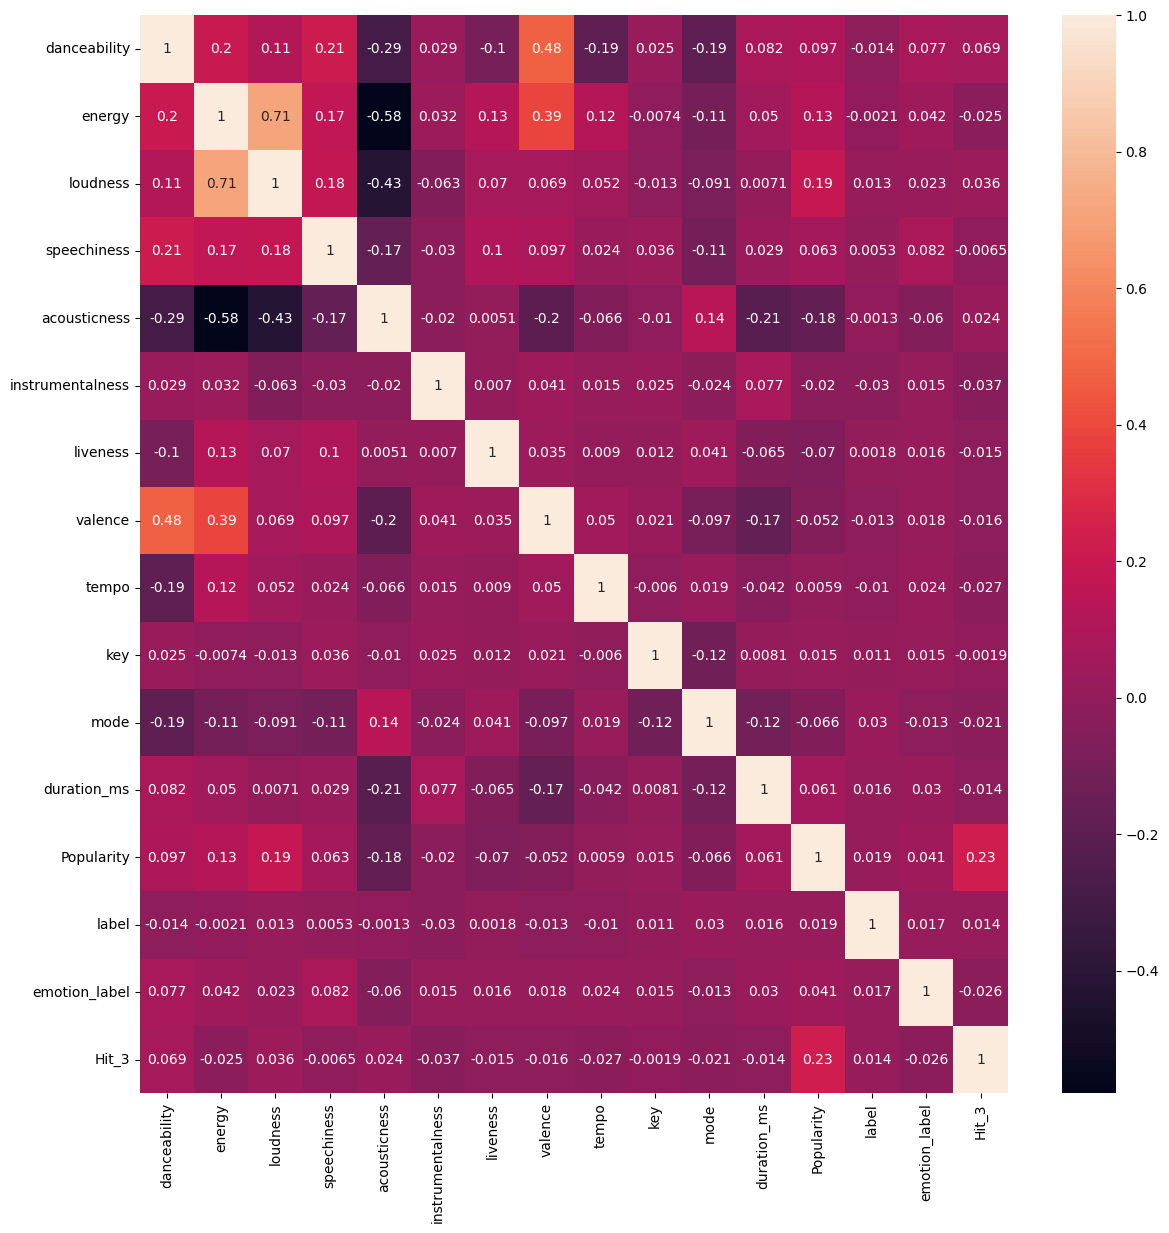

In [30]:
plt.figure(figsize=(14,14))
correl = df.corr()
sns.heatmap(correl,annot=True)

In [31]:
correl

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,mode,duration_ms,Popularity,label,emotion_label,Hit_3
danceability,1.000000,0.198018,0.111736,0.213698,-0.290995,0.029419,-0.100841,0.475021,-0.186441,0.024730,-0.189376,0.081653,0.097319,-0.014367,0.076690,0.069387
energy,0.198018,1.000000,0.714497,0.172698,-0.579731,0.031616,0.127974,0.385338,0.120975,-0.007444,-0.108097,0.050055,0.126424,-0.002137,0.042167,-0.024716
loudness,0.111736,0.714497,1.000000,0.175783,-0.425053,-0.063207,0.070496,0.069263,0.051803,-0.012937,-0.091119,0.007086,0.190221,0.013464,0.022515,0.036183
speechiness,0.213698,0.172698,0.175783,1.000000,-0.170929,-0.029961,0.103192,0.096803,0.024217,0.036208,-0.106428,0.028961,0.063117,0.005288,0.081761,-0.006506
acousticness,-0.290995,-0.579731,-0.425053,-0.170929,1.000000,-0.020373,0.005081,-0.202690,-0.066351,-0.010152,0.141878,-0.213031,-0.176369,-0.001316,-0.060077,0.024166
instrumentalness,0.029419,0.031616,-0.063207,-0.029961,-0.020373,1.000000,0.006974,0.041007,0.015327,0.025182,-0.023528,0.077227,-0.019770,-0.030121,0.015389,-0.037450
liveness,-0.100841,0.127974,0.070496,0.103192,0.005081,0.006974,1.000000,0.034942,0.009022,0.011685,0.040874,-0.064754,-0.070468,0.001763,0.016403,-0.015004
valence,0.475021,0.385338,0.069263,0.096803,-0.202690,0.041007,0.034942,1.000000,0.050256,0.021429,-0.097040,-0.172440,-0.051755,-0.013029,0.017972,-0.016315
tempo,-0.186441,0.120975,0.051803,0.024217,-0.066351,0.015327,0.009022,0.050256,1.000000,-0.005951,0.018918,-0.042496,0.005950,-0.010494,0.024350,-0.026836
key,0.024730,-0.007444,-0.012937,0.036208,-0.010152,0.025182,0.011685,0.021429,-0.005951,1.000000,-0.124319,0.008148,0.014652,0.010764,0.015191,-0.001907


# Seperative the categorical and numeric features

In [32]:
df.nunique()

lyrics              3648
title               3447
artist              1263
TrackID             3651
danceability         687
energy               805
loudness            3137
speechiness          856
acousticness        1695
instrumentalness    1582
liveness            1065
valence              881
tempo               3545
key                   12
mode                   2
duration_ms         3237
Popularity            90
label                  2
emotion_label          6
Hit_3                  2
dtype: int64

In [33]:
categorical = [x for x in df.columns if df[x].nunique()< 15]

In [34]:
categorical

['key', 'mode', 'label', 'emotion_label', 'Hit_3']

In [35]:
df = df.drop(['lyrics'], axis=1)

In [36]:
df = df.drop(['title', 'artist', 'TrackID', 'Popularity'], axis=1)

In [37]:
numeric = [x for x in df.columns if df[x].nunique() > 15]

In [38]:
numeric

['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms']

In [39]:
numeric

['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms']

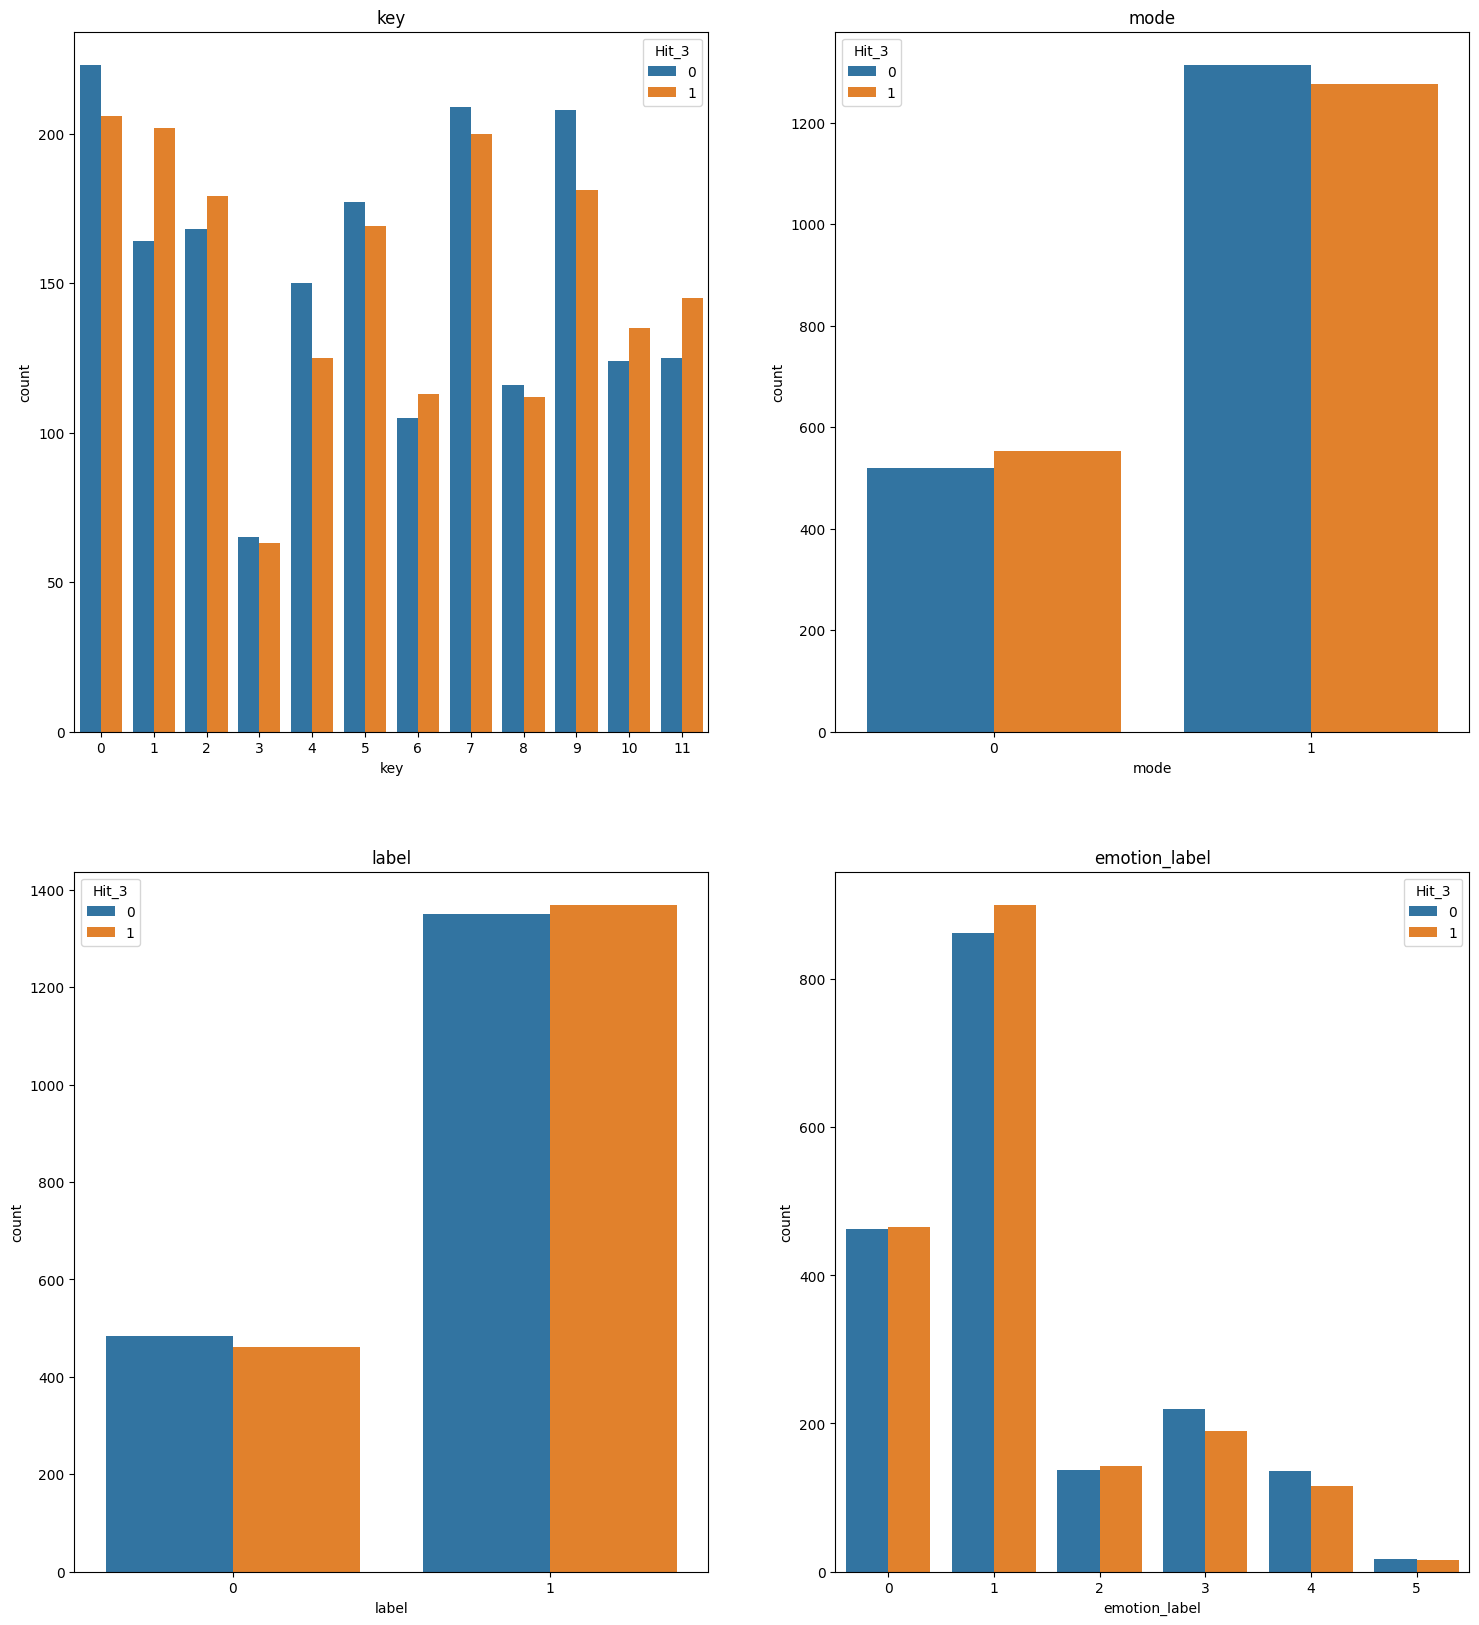

In [40]:
plt.figure(figsize=(18,20))
i = 1
for features in categorical[:-1]:
    plt.subplot(2,2,i)
    sns.countplot(x=df[features],hue=data.Hit_3).set_title(features)
    i=i+1
plt.show()

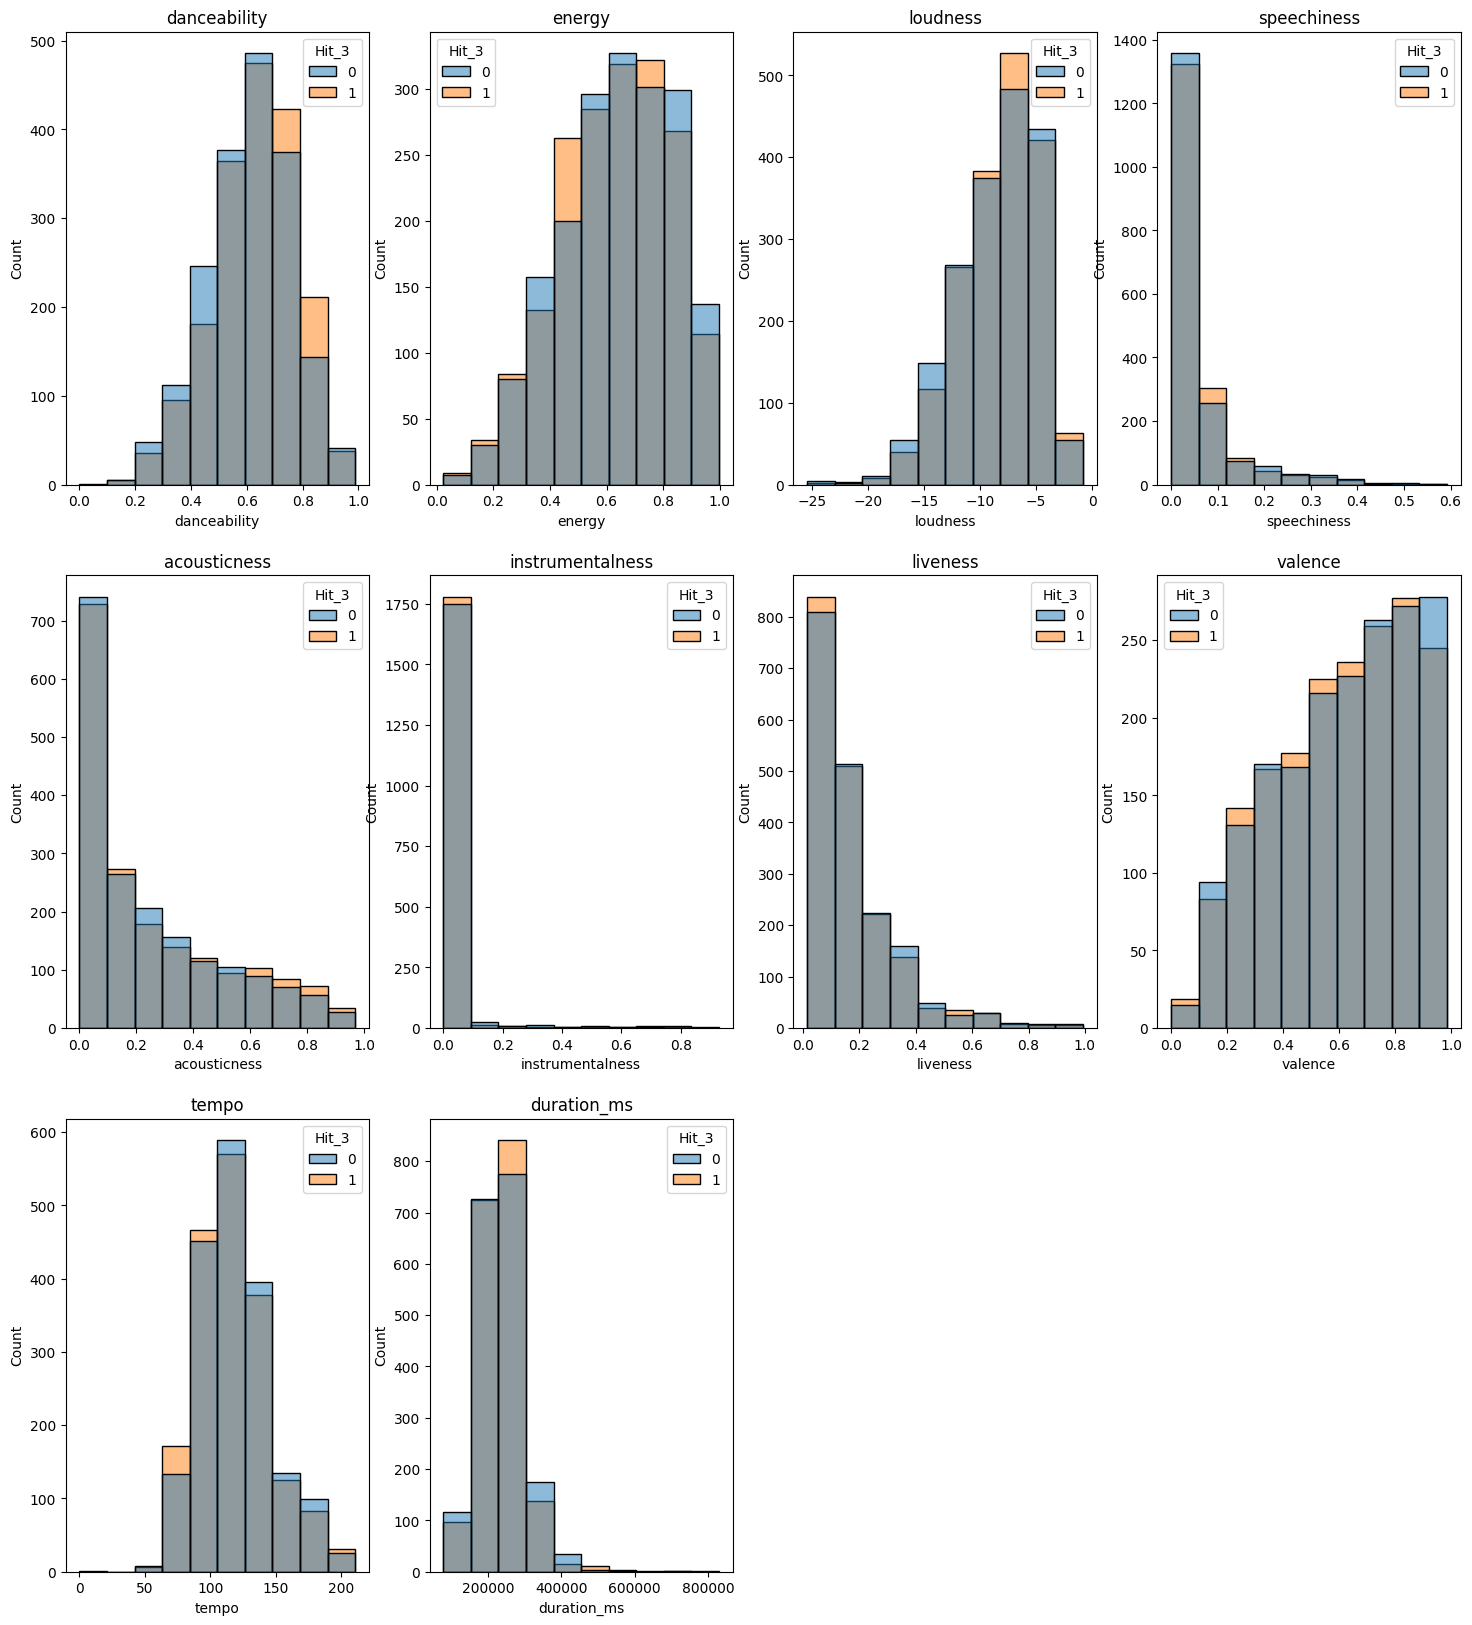

In [41]:
plt.figure(figsize=(18,20))
i = 1
for features in numeric:
    plt.subplot(3,4,i)
    sns.histplot(x=df[features],hue= df.Hit_3, bins=10).set_title(features)
    i=i+1
plt.show()

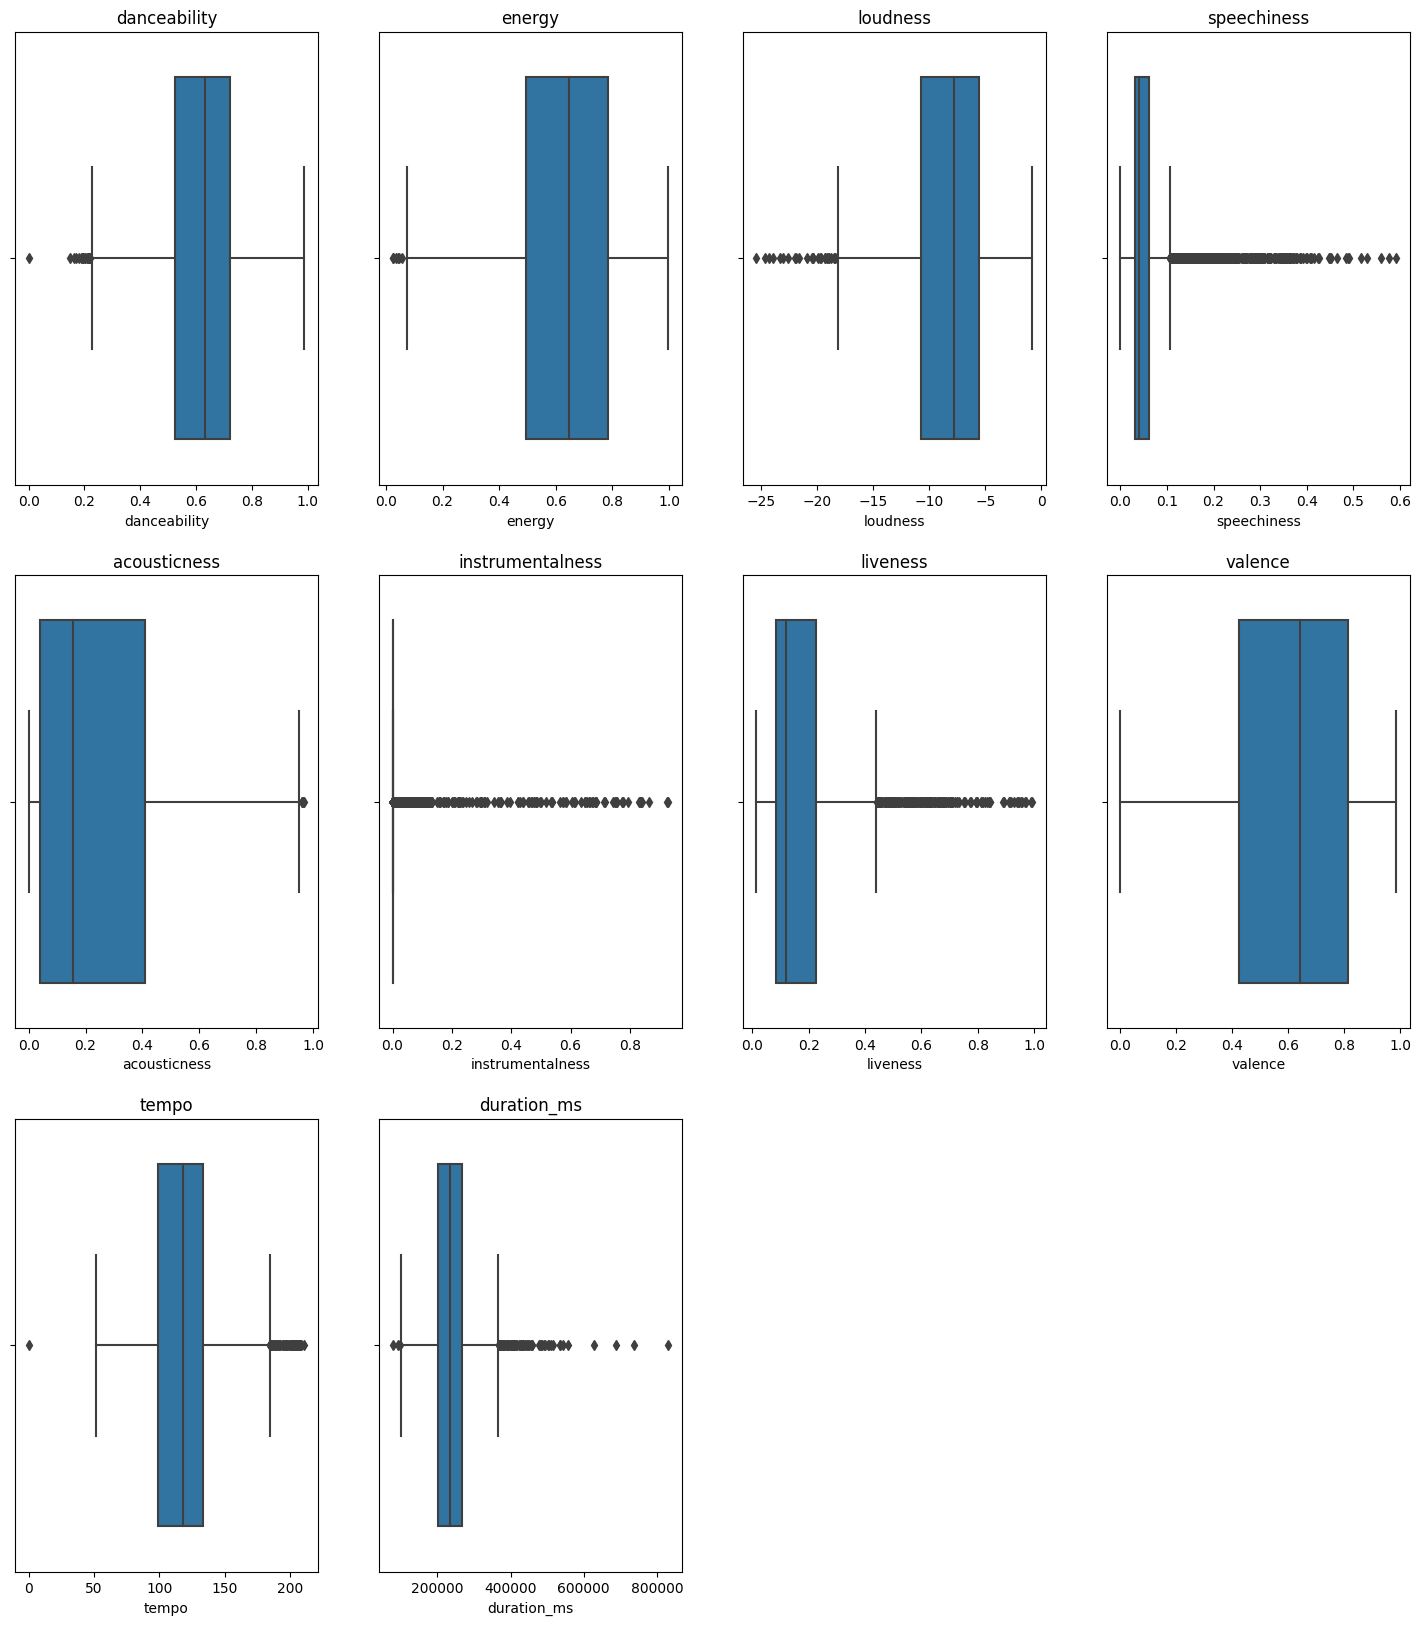

In [42]:
plt.figure(figsize=(18,20))
i = 1
for features in numeric:
    plt.subplot(3,4,i)
    sns.boxplot(x=df[features]).set_title(features)
    i=i+1
plt.show()

# Feature Engineering

# Import Dataset and Preprocessing Steps

In [43]:
import pandas as pd

df = pd.read_csv('/content/gdrive/My Drive/Colab Datasets/dataset_ML_complete.csv')

In [44]:
df = df.drop(['genre', 'num_syllables', 'pos', 'year', 'fog_index',
       'flesch_index', 'num_lines', 'sentiment','f_k_grade', 'difficult_words', 'num_dupes', 'number_of_tokens',
       'number_of_types', 'decades', 'stemmed_text', 'POS_tags', 'POS','values', 'pred'], axis=1)

In [45]:
df = df.drop(['playlistID', 'TrackName', 'SampleURL', 'ReleaseYear', 'Genres', 'score'], axis=1)

In [46]:
df = df.drop(['Hit', 'Hit_2'], axis=1)

In [47]:
df.Hit_3 = df.Hit_3.replace({'yes': 1, 'no': 0})

In [48]:
from collections import Counter

Counter(df.Hit_3)

Counter({1: 1830, 0: 1834})

In [49]:
#df.label = df.label.replace({'POSITIVE': 1, 'NEGATIVE': 0})

In [50]:
df.head(5)

,lyrics,title,artist,TrackID,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,mode,duration_ms,Popularity,label,emotion_label,Hit_3
0,look into my eyes you will seewhat you mean t...,(Everything I Do) I Do It For You,Bryan Adams,1Eb90nmqTrxylKFhcUzW8P,0.533,0.360,-12.633,0.0282,0.0805,0.000010,0.0631,0.299,131.229,1,1,393640,77.0,POSITIVE,joy,1
1,i can't get no satisfactioni can't get no sati...,(I Can't Get No) Satisfaction,Rolling Stones,2PzU4IB8Dr6mxV3lHuaG34,0.723,0.863,-7.890,0.0338,0.0383,0.031700,0.1280,0.931,136.302,2,1,222813,78.0,NEGATIVE,joy,1
2,our life together is so precious togetherwe ha...,(Just Like) Starting Over,John Lennon,5y0YreEOnQiKFAnCrcFIXz,0.701,0.790,-6.160,0.0725,0.3010,0.000061,0.1790,0.421,99.104,9,1,236547,61.0,POSITIVE,joy,1
3,love is higher than a mountain love is thicker...,(Love Is) Thicker Than Water,Andy Gibb,3jdBf1cJ2QmTzNUixplppA,0.582,0.462,-9.882,0.0254,0.1370,0.000050,0.0755,0.528,96.361,6,0,255960,47.0,POSITIVE,sadness,1
4,sittin' in the morning suni'll be sittin' when...,(Sittin' On) The Dock Of The Bay,Otis Redding,3zBhihYUHBmGd2bcQIobrF,0.769,0.367,-11.226,0.0312,0.6840,0.000016,0.0810,0.535,103.621,2,1,163756,80.0,NEGATIVE,joy,1


In [51]:
Counter(df.label)

Counter({'POSITIVE': 2719, 'NEGATIVE': 945})

In [52]:
Counter(df.emotion_label)

Counter({' joy': 1762,
         ' sadness': 928,
         ' fear': 252,
         ' love': 280,
         ' anger': 409,
         ' surprise': 33})

In [53]:
#df.emotion_label = df.emotion_label.replace({' sadness': 0, ' joy': 1, ' love': 2, ' anger': 3, ' fear': 4, ' surprise': 5})

In [54]:
df = df.drop(['title','artist','TrackID'],axis=1)

In [55]:
df.columns

Index(['lyrics', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'key', 'mode', 'duration_ms', 'Popularity', 'label', 'emotion_label',
       'Hit_3'],
      dtype='object')

In [56]:
df['label'] = df['label'].astype("category")

In [57]:
df['emotion_label'] = df['emotion_label'].astype("category")

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3664 entries, 0 to 3663
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   lyrics            3664 non-null   object  
 1   danceability      3664 non-null   float64 
 2   energy            3664 non-null   float64 
 3   loudness          3664 non-null   float64 
 4   speechiness       3664 non-null   float64 
 5   acousticness      3664 non-null   float64 
 6   instrumentalness  3664 non-null   float64 
 7   liveness          3664 non-null   float64 
 8   valence           3664 non-null   float64 
 9   tempo             3664 non-null   float64 
 10  key               3664 non-null   int64   
 11  mode              3664 non-null   int64   
 12  duration_ms       3664 non-null   int64   
 13  Popularity        3664 non-null   float64 
 14  label             3664 non-null   category
 15  emotion_label     3664 non-null   category
 16  Hit_3             3664 n

# Preprocessing the Text data

In [59]:
import re
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [60]:
# Assuming you have a 'lyrics' column containing the text data
df['lyrics'] = df['lyrics'].apply(preprocess_text)

# Splitting the data into dependent and independent features

In [61]:
X = df.drop('Hit_3',axis=1)

In [62]:
X.columns

Index(['lyrics', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'key', 'mode', 'duration_ms', 'Popularity', 'label', 'emotion_label'],
      dtype='object')

In [63]:
y = df["Hit_3"]

# TF-IDF Vectorizer for Text Data

In [64]:
tfidf_vectorizer = TfidfVectorizer()
X_text = tfidf_vectorizer.fit_transform(X['lyrics'])

# Combine Text- & Numeric Features

In [65]:
# Combine Text- & Numeric Features
X_combined = pd.concat([X.drop('lyrics', axis=1), pd.DataFrame(X_text.toarray())], axis=1)

# Training- & Testsplit

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
# Splitting into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.20)

# Model Selection

In [68]:
from xgboost import XGBClassifier

In [69]:
classifier = XGBClassifier(enable_categorical=True, tree_method='hist')

# Import Randomized Search Cross Validation

In [70]:
from sklearn.model_selection import RandomizedSearchCV

# Parameter Selection

In [71]:
params = {
    'learning_rate':[0.05,0.10,0.15,0.20,0.25,0.30],
    'max_depth': [3,4,5,6,8,10,12,15],
    'min_child_weight':[1,3,5,7],
    'gamma':[0.0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7]
}

In [72]:
random_search = RandomizedSearchCV(classifier, param_distributions=params, n_iter=5, scoring="roc_auc", n_jobs=-1, cv=5, verbose=3)

In [ ]:
random_search.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
random_search.best_estimator_

In [ ]:
classifier= XGBClassifier(enable_categorical=True, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, device='cpu',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, #predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='hist', validate_parameters=1,
              verbosity=None)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report

In [ ]:
cross = cross_val_score(classifier, x_train, y_train, cv=10, verbose=0)

In [ ]:
print("Accuracy after cross validation is: {}".format(cross.mean()*100))

# Prediction

In [ ]:
classifier.fit(x_train,y_train)

In [ ]:
y_pred = classifier.predict(x_test)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt="g")
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Visualise classification report

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')

    # Extract class names and metrics
    class_names = []
    precision = []
    recall = []
    f1_score = []
    #support = []

    for line in lines[2:4]:
        row = line.split()
        class_names.append(row[0])
        precision.append(float(row[1]))
        recall.append(float(row[2]))
        f1_score.append(float(row[3]))
        #support.append(int(row[4]))

    # Create a bar chart
    width = 0.2
    x = range(len(class_names))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x, precision, width, label='Precision')
    ax.bar([i + width for i in x], recall, width, label='Recall')
    ax.bar([i + 2 * width for i in x], f1_score, width, label='F1-Score')
    #ax.bar([i + 3 * width for i in x], support, width, label='Support')

    ax.set_xlabel('Classes')
    ax.set_ylabel('Metrics')
    ax.set_title('Classification Metrics')
    ax.set_xticks([i + 1.5 * width for i in x])
    ax.set_xticklabels(class_names)
    ax.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Classification report as a string (replace with your actual report)
report = """              precision    recall  f1-score   support

           0       0.56      0.51      0.53       184
           1       0.53      0.58      0.55       177

    accuracy                           0.54       361
   macro avg       0.54      0.54      0.54       361
weighted avg       0.54      0.54      0.54       361"""

# Call the function to plot the classification report
plot_classification_report(report)


# Feature Importance

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(classifier, max_num_features=20)  # Set max_num_features to 5
plt.rcParams['figure.figsize'] = [6, 4]  # Adjust the figure size if needed
plt.show()


# Test with another device

In [ ]:
classifier = XGBClassifier(enable_categorical=True, tree_method='hist', device = "cuda")

In [ ]:
random_search = RandomizedSearchCV(classifier, param_distributions=params, n_iter=5, scoring="roc_auc", n_jobs=-1, cv=5, verbose=3)

In [ ]:
random_search.fit(x_train, y_train)

In [ ]:
random_search.best_estimator_

In [ ]:
classifier= XGBClassifier(enable_categorical=True, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, #predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='hist', device = "cuda", validate_parameters=1,
              verbosity=None)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report

In [ ]:
cross = cross_val_score(classifier, x_train, y_train, cv=10, verbose=0)

In [ ]:
print("Accuracy after cross validation is: {}".format(cross.mean()*100))

# Prediction

In [ ]:
classifier.fit(x_train,y_train)

In [ ]:
y_pred = classifier.predict(x_test)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt="g")
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Visualise classification report

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')

    # Extract class names and metrics
    class_names = []
    precision = []
    recall = []
    f1_score = []
    #support = []

    for line in lines[2:4]:
        row = line.split()
        class_names.append(row[0])
        precision.append(float(row[1]))
        recall.append(float(row[2]))
        f1_score.append(float(row[3]))
        #support.append(int(row[4]))

    # Create a bar chart
    width = 0.2
    x = range(len(class_names))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x, precision, width, label='Precision')
    ax.bar([i + width for i in x], recall, width, label='Recall')
    ax.bar([i + 2 * width for i in x], f1_score, width, label='F1-Score')
    #ax.bar([i + 3 * width for i in x], support, width, label='Support')

    ax.set_xlabel('Classes')
    ax.set_ylabel('Metrics')
    ax.set_title('Classification Metrics')
    ax.set_xticks([i + 1.5 * width for i in x])
    ax.set_xticklabels(class_names)
    ax.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Classification report as a string (replace with your actual report)
report = """precision    recall  f1-score   support

           0       0.57      0.52      0.55       184
           1       0.54      0.59      0.57       177

    accuracy                           0.56       361
   macro avg       0.56      0.56      0.56       361
weighted avg       0.56      0.56      0.56       361
"""

# Call the function to plot the classification report
plot_classification_report(report)


# Feature Importance

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(classifier, max_num_features=20)  # Set max_num_features to 5
plt.rcParams['figure.figsize'] = [6, 4]  # Adjust the figure size if needed
plt.show()
